# Problem 3 - Sampling BigGANs

First, switch to GPU.

BigGAN (Brock, Andrew, Jeff Donahue, and Karen Simonyan. "Large scale gan training for high fidelity natural image synthesis.") is in essence very similar to conditional DC-GANs we saw previously, but with substantially deeper and more complex Generators and Discriminators (ResNets), and trained with a few tricks to improve performance.

We will use a BigGAN trained on ImageNet for many iterations using many GPUs. The pretrained BigGAN is available for download from tf_hub.

The downloaded object is not a tf.keras.Model but a tf.function, we will treat it as a black-box function.

1.  Use the provided code to download the BigGAN generator and list the inputs of the function. Explain what each input is.

2.  Complete the code under the section "consistency in z space." We wish to generate one sample of a white wolf and one sample of a grey wolf using the same random vector `z`. You can find the class indices here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a. You need to one-hot encode the `y` argument (use `tf.onehot`, and remember how many classes does ImageNet has).

3.  What is the range of the generated samples (minimum, maximum value)? How to rescale them back to natural images? Write a function `rescale_samples(samples)` to do that.

4.  Comment on the generated samples.

5.  Create a function `interpolate_line(z_1, z_1, num_steps)` which returns a tf.Tensor `T` of shape `(num_steps, 128)` where the rows of the returned tensor correspond to vectors in the linear interpolation between `z_1` and `z_2` i.e. `T[0] = z_1, ..., T[-1] = z_2`

6.  Complete the code under the section "Linear interpolation" to generate a "linear walk" between two generated images of a tibetan terrier using `num_steps=16`

7.  Comment on the smoothness of the transitions.

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
#import logging
#logging.getLogger('tensorflow').setLevel(logging.ERROR)
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
# This line introduces a lot of warnings from TF, you can clear the output of the cell (right click - clear output)
module = hub.load('https://tfhub.dev/deepmind/biggan-512/2').signatures['default'] # takes a couple minutes

In [ ]:
# inputs of the tf.function `module`
[input for input in module.inputs if not input.dtype == tf.resource]
# 1. 
# Explain what each input is
# y is the imagenet label of the input
# z is the noise vector
# The "truncation" is the scalar truncation value

[<tf.Tensor 'y:0' shape=(None, 1000) dtype=float32>,
 <tf.Tensor 'z:0' shape=(None, 128) dtype=float32>,
 <tf.Tensor 'truncation:0' shape=() dtype=float32>]

## Consistency in z space

In [ ]:
truncation = 0.5  
tf.random.set_seed(seed=2020)
z = truncation * tf.random.truncated_normal([128])
z = tf.stack([z,z])
tf.print(z.shape)
# 2.
# YOUR CODE HERE
#y_idx = tf.random.uniform([2], maxval=1000, dtype=tf.int32) 
y_idx = tf.constant([269,270], dtype=tf.int32)
tf.print(y_idx.shape)
y = tf.one_hot(y_idx,1000)
samples = module(y=y, z=z, truncation=tf.constant(truncation))  # Takes ~ 30 sec
samples = samples['default'] # module return a dictionary

TensorShape([2, 128])
TensorShape([2])


In [ ]:
# 3.
# YOUR CODE HERE
# range of samples?
#print(range(len(samples)))
print(np.amin(samples))
print(np.amax(samples))
print(samples.shape)
#plt.imshow(rescaled_samples[1])
#plt.show()
# In the range of samples generated, the minimum value is -0.99173063 and the maximun value is 0.98846996
# Since pixel values are unsigned integers between 0 and 255, we should
# rescale the samples from 0 to 255

-0.99173063
0.98846996
(2, 512, 512, 3)


In [ ]:
# 3.
def rescale_samples(samples):
  # YOUR CODE HERE 
  samples = samples*0.5 + 0.5
  return samples

0.004134685
0.994235
(2, 512, 512, 3)


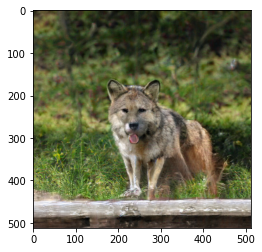

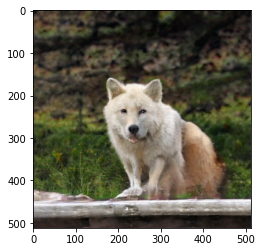

In [ ]:
rescaled_samples = rescale_samples(samples)
print(np.amin(rescaled_samples))
print(np.amax(rescaled_samples))
print(rescaled_samples.shape)
for i in range(len(rescaled_samples)):
  plt.imshow(rescaled_samples[i])
  plt.show()

# 4. COMMENT
# Before denormalizing the images were noisy because of the negative pixels
# Now that the mininimun pixels of the samples is beign denormalized the images look better
# Also the first axis of the sample tensor matrix (2), constains the number of images, if we change the 
# Axis to 8, then 8 images will be printed

## Linear interpolation

In [ ]:

def interpolate_line(z_1, z_2, num_steps):
  # YOUR CODE HERE
  alpha = np.linspace(z_1,z_2,num_steps) 
  diff = z_2 - z_1
  T = tf.abs(z_1 + tf.math.multiply(alpha, diff))
  return T

In [ ]:
num_steps = 16
truncation = 0.5  
tf.random.set_seed(seed=2020)
z_1 = truncation * tf.random.truncated_normal([128])
tf.random.set_seed(seed=2021)
z_2 = truncation * tf.random.truncated_normal([128])
# 6.
# YOUR CODE HERE
z =  interpolate_line(z_2, z_1, 16)
tf.print(z.shape)
# z = ...
y_idx = tf.constant([200], dtype=tf.int32,shape=(num_steps))
tf.print(y_idx)
y =  tf.one_hot(y_idx,1000)

tf.print(y.shape)

samples = module(y=y, z=z, truncation=tf.constant(truncation))  # Takes ~ 30 sec
samples = samples['default'] # module return a dictionary

TensorShape([16, 128])
[200 200 200 ... 200 200 200]
TensorShape([16, 1000])


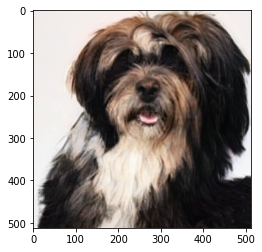

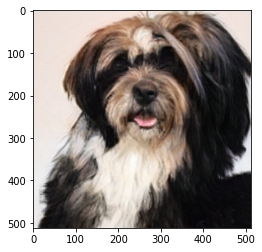

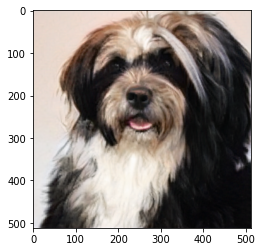

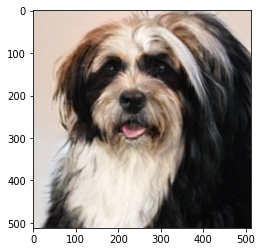

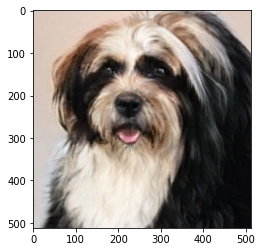

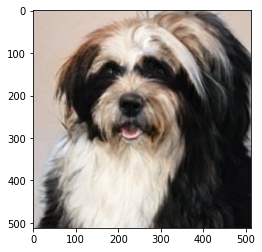

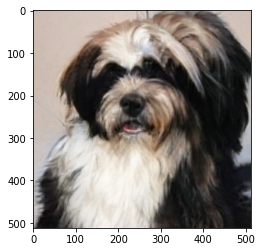

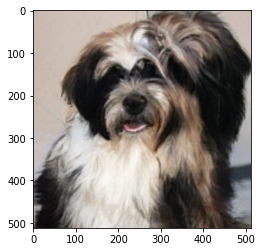

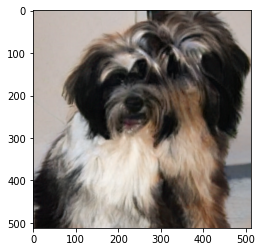

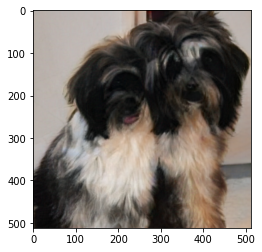

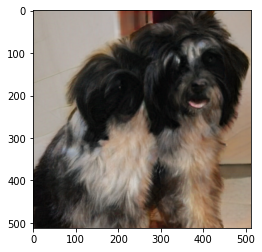

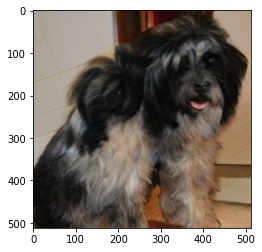

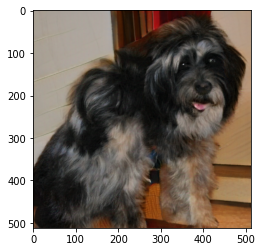

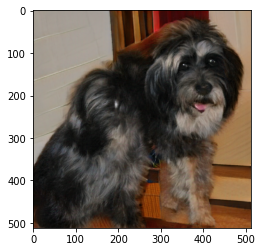

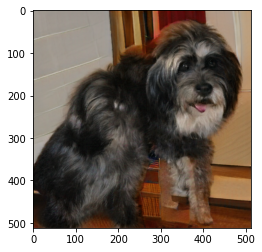

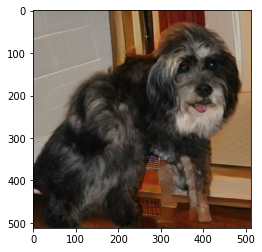

In [ ]:
rescaled_samples = rescale_samples(samples)
for i in range(len(rescaled_samples)):
  plt.imshow(rescaled_samples[i])
  plt.show()

# 7.
# COMMENT
# The smoothness of the transition is due to the estimation of the unkown values done by the interpolation of each the know  pixel values in 
# each one of the images